In [2]:
import glob
import sys
sys.path.append("/home/bhuth/gnn/acorn")

In [3]:
from acorn.utils.loading_utils import handle_edge_features

In [4]:
import torch
import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
def cantor_pairing(a):
    a = np.sort(a, axis=0)
    return a[1] + ((a[0] + a[1]) * (a[0] + a[1] + 1)) // 2


def effpur(true, pred):
    cantor_true = cantor_pairing(true)
    cantor_pred = cantor_pairing(pred)
    cantor_intersection = np.intersect1d(cantor_true, cantor_pred)

    return {
        "eff": len(cantor_intersection)
        / len(cantor_true),  # if len(cantor_true) > 0 else 0,
        "pur": len(cantor_intersection)
        / len(cantor_pred),  # if len(cantor_pred) > 0 else 0,
    }

In [6]:
for f in glob.glob("../tmp/ctd23/feature_store/**/*.pyg"):
    b = torch.load(f, map_location="cpu")
    print(f"{f}, hits: {len(b.module_id)}, track edges: {b.track_edges.shape[1]}")

../tmp/ctd23/feature_store/trainset/event000000000-graph.pyg, hits: 268503, track edges: 104852
../tmp/ctd23/feature_store/valset/event000000008-graph.pyg, hits: 248400, track edges: 93715
../tmp/ctd23/feature_store/valset/event000000006-graph.pyg, hits: 268080, track edges: 103557
../tmp/ctd23/feature_store/valset/event000000003-graph.pyg, hits: 281917, track edges: 109389
../tmp/ctd23/feature_store/valset/event000000002-graph.pyg, hits: 300240, track edges: 115950
../tmp/ctd23/feature_store/valset/event000000007-graph.pyg, hits: 301102, track edges: 116163
../tmp/ctd23/feature_store/valset/event000000009-graph.pyg, hits: 315584, track edges: 121288
../tmp/ctd23/feature_store/valset/event000000005-graph.pyg, hits: 314595, track edges: 123207
../tmp/ctd23/feature_store/valset/event000000004-graph.pyg, hits: 331266, track edges: 130374
../tmp/ctd23/feature_store/testset/event000000001-graph.pyg, hits: 351293, track edges: 134084


In [7]:
with open("../ctd23/data/gnn.pt.hparams.json") as f:
    hparams = yaml.load(f, Loader=yaml.Loader)
hparams

"batchnorm":                              True
"bn_track_running_stats":                 False
"checkpointing":                          False
"concat":                                 True
"data_split":                             [7800, 1000, 1000]
"dataset_class":                          GraphDataset
"debug":                                  False
"edge_cut":                               0.5
"edge_features":                          ['dr', 'dphi', 'dz', 'deta', 'phislope', 'rphislope']
"edge_net_recurrent":                     False
"edge_output_transform_final_activation": None
"edge_output_transform_final_batch_norm": False
"factor":                                 0.9
"gpus":                                   [1]
"hidden":                                 128
"hidden_activation":                      ReLU
"in_out_diff_agg":                        True
"input_dir":                              /sps/atlas/s/scaillou/itk/GNN4ITkTeam/data/ATLAS-P2-ITK-23-00-03_Rel.21.9/ttbar/module_

In [8]:
batch = torch.load("../tmp/ctd23/gnn/trainset/event000000000.pyg", map_location="cpu")
for feat, scale in zip(hparams["node_features"], hparams["node_scales"]):
    batch[feat] /= scale
batch

DataBatch(x=[268503], edge_index=[2, 1340936], y=[1340936], cluster_x_2=[268503], eta_angle_2=[268503], cluster_eta_2=[268503], hit_id=[268503], phi_angle_2=[268503], z=[268503], cluster_x_1=[268503], cluster_phi_1=[268503], phi_angle_1=[268503], cluster_z_2=[268503], cluster_eta_1=[268503], cluster_y_2=[268503], cluster_y_1=[268503], cluster_z_1=[268503], module_id=[268503], eta=[268503], region=[268503], phi=[268503], eta_angle_1=[268503], norm_y_1=[268503], norm_x_2=[268503], norm_z_1=[268503], norm_y_2=[268503], r=[268503], cluster_phi_2=[268503], cluster_r_1=[268503], norm_z_2=[268503], norm_x_1=[268503], cluster_r_2=[268503], track_edges=[2, 104852], radius=[104852], pt=[104852], redundant_split_edges=[104852], pdgId=[104852], eta_particle=[104852], primary=[104852], particle_id=[104852], nhits=[104852], config=[2], event_id=[1], truth_map=[104852], weights=[1340936], dr=[1340936], dphi=[1340936], dz=[1340936], deta=[1340936], phislope=[1340936], rphislope=[1340936], batch=[26850

### Check metrics after module map stage

In [9]:
target_mask = (batch.pt > 1000) & (batch.nhits > 2) & (abs(batch.pdgId) != 11) & batch.primary.bool() & (abs(batch.eta_particle) < 4)
batch.target_edges = batch.track_edges[:, target_mask]

In [10]:
effpur(batch.target_edges.numpy(), batch.edge_index.numpy())

{'eff': 0.9946421096693177, 'pur': 0.00886022897438804}

In [11]:
effpur(batch.track_edges.numpy(), batch.edge_index.numpy())

{'eff': 0.5682008926868348, 'pur': 0.04442941348431245}

### Run inference with torchscript

In [12]:
x = torch.vstack([ batch[feat] for feat in hparams["node_features"] ]).T
x.shape

torch.Size([268503, 12])

In [13]:
edge_attributes = torch.vstack([ batch[feat] for feat in hparams["edge_features"] ]).T
edge_attributes.shape

torch.Size([1340936, 6])

In [17]:
{"reserved": torch.cuda.memory_reserved(0) / (1000*1000), "allocated": torch.cuda.memory_allocated(0) / (1000*1000)}

{'reserved': 8.388608, 'allocated': 7.944192}

In [24]:
gnn = torch.jit.load("../ctd23/data/gnn.pt").cuda()

In [25]:
{"reserved": torch.cuda.memory_reserved(0) / (1000*1000), "allocated": torch.cuda.memory_allocated(0) / (1000*1000)}

{'reserved': 16.777216, 'allocated': 7.944192}

In [37]:
n_edges = 10000
scores = gnn(x.to(torch.float32).cuda(), batch.edge_index[:, :n_edges].cuda(), edge_attributes.to(torch.float32)[:n_edges].cuda()).detach().cpu()
scores = torch.sigmoid(scores)

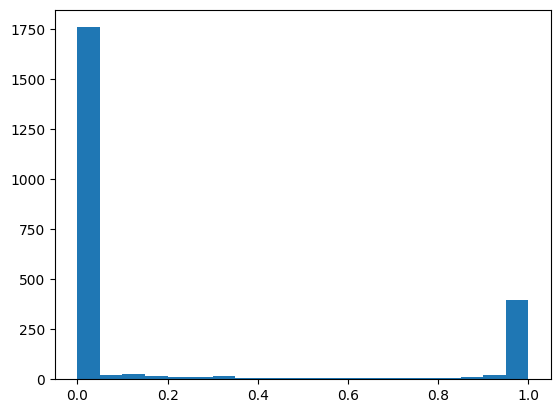

In [15]:
_, bins, _ = plt.hist(scores, bins=20)

In [17]:
effpur(batch.track_edges.numpy(), scored_edge_index.numpy())

{'eff': 0.30811179277436945, 'pur': 0.9720430107526882}

In [16]:
scored_edge_index = batch.edge_index[:, scores > 0.5]

In [18]:
effpur(batch.target_edges.numpy(), scored_edge_index.numpy())

{'eff': 0.987012987012987, 'pur': 0.49032258064516127}

### Compare to acorn

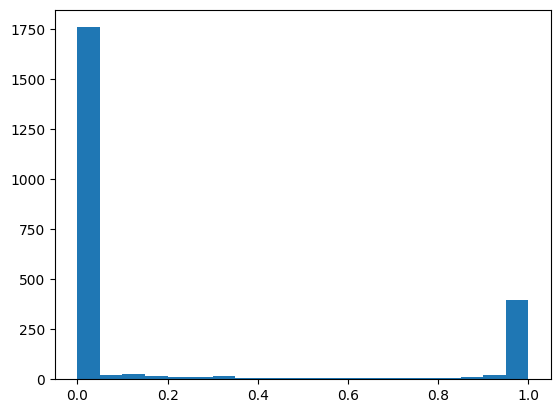

In [19]:
_ = plt.hist(batch.scores, bins=20)

In [20]:
effpur(batch.track_edges.numpy(), batch.edge_index[:, batch.scores > 0.5])

{'eff': 0.30811179277436945, 'pur': 0.9720430107526882}

In [21]:
effpur(batch.target_edges.numpy(), batch.edge_index[:, batch.scores > 0.5])

{'eff': 0.987012987012987, 'pur': 0.49032258064516127}

In [66]:
rename_dict = {
    "deltaR": "dr",
    " deltaEta": "deta",
    " deltaZ": "dz",
    " deltaPhi": "dphi",
    " phiSlope": "phislope",
    " rPhiSlope": "rphislope"
}

acts_features = pd.read_csv("../edge_features.csv", index_col=False)
acts_features.rename(columns=rename_dict, inplace=True)

In [67]:
acts_features.head(3)

,dr,dphi,dz,deta,phislope,rphislope
0,0.004368,1.99761,-0.057,-0.002614,457.321,18.5404
1,0.004572,1.99779,-0.061,-0.004409,436.916,19.6663
2,0.003686,1.99817,-0.049,-0.004778,542.142,19.7960


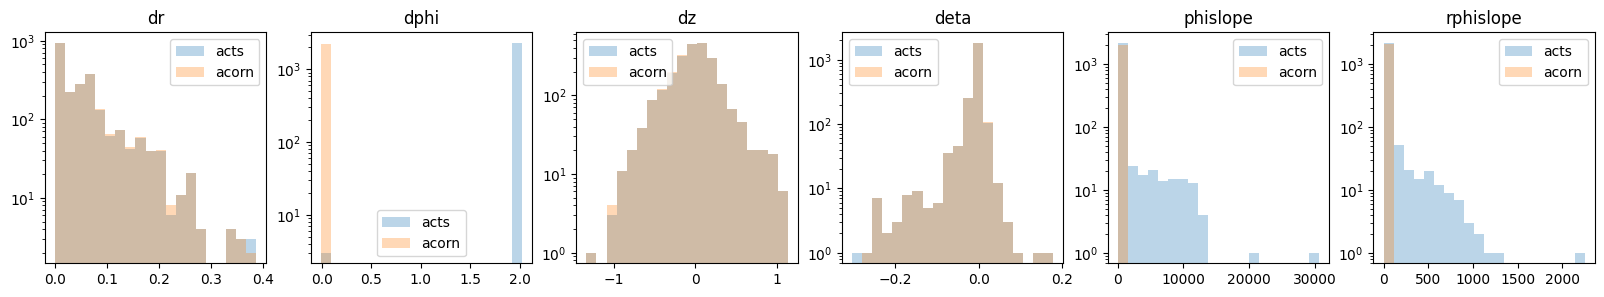

In [71]:
fig, axes = plt.subplots(1, len(hparams["edge_features"]), figsize=(20,3))

for feat, ax in zip(hparams["edge_features"], axes):
    _, bins, _ = ax.hist(acts_features[feat], bins=20, alpha=0.3, label="acts")
    _, bins, _ = ax.hist(batch[feat], bins=bins, alpha=0.3, label="acorn")
    ax.set_title(feat)
    ax.set_yscale('log')
    ax.legend()